<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.093750
 668 2015-08-10 23:00:00  0.089844
 669 2015-08-10 23:15:00  0.093750
 670 2015-08-10 23:30:00  0.097656
 671 2015-08-10 23:45:00  0.074219
 
 [64072 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.062500
 668 2015-08-10 23:00:00  0.078125
 669 2015-08-10 23:15:00  0.062500
 670 2015-08-10 23:30:00  0.109375
 671 2015-08-10 23:45:00  0.273438
 
 [64320 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [4]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [5]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63832,2015-08-10 22:45:00,0.093750,0.062500,0.125000,0.234375,1.750000
63833,2015-08-10 23:00:00,0.089844,0.078125,0.117188,0.218750,1.781250
63834,2015-08-10 23:15:00,0.093750,0.062500,0.132812,0.218750,1.718750
63835,2015-08-10 23:30:00,0.097656,0.109375,0.179688,0.203125,2.937500


<h4>将一二层数据相加</h4>

In [6]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [7]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [8]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [9]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [10]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [11]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-10 19:00:00,8.500000,1.277344,3.750000,13.527344
2015-08-10 20:00:00,3.531250,1.292969,2.382812,7.207031
2015-08-10 21:00:00,3.312500,1.203125,1.117188,5.632812
2015-08-10 22:00:00,5.000000,1.035156,1.234375,7.269531


<AxesSubplot:>

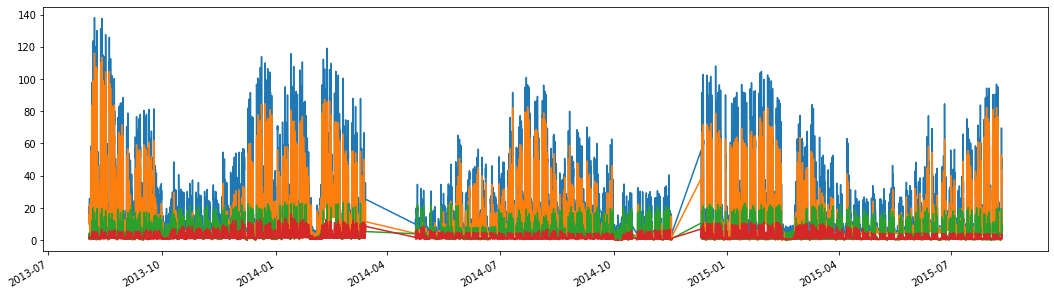

In [12]:
data["value_total"].plot(figsize=(18,5))
data["value_air"].plot(figsize=(18,5))
data["value_light"].plot(figsize=(18,5))
data["value_socket"].plot(figsize=(18,5))

<h3>合并天气数据</h3>

In [13]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [14]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [15]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["temp"] = data["temp"].rolling("12H").mean()
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)
# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,workday,hour,week,day,month,year,is_summer,is_winter
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,东南风,159,9,71,0,0,5,3,8,2013,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,东南风,155,8,75,0,1,5,3,8,2013,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,东南风,150,8,54,0,2,5,3,8,2013,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,东南风,151,8,25,0,3,5,3,8,2013,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,东南风,151,8,35,0,4,5,3,8,2013,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,东北风,43,11,1,1,19,0,24,8,2015,1,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,东北风,45,9,0,1,20,0,24,8,2015,1,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,东北风,35,7,2,1,21,0,24,8,2015,1,0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [16]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,is_summer,is_winter,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,1,0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [17]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [18]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [19]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [20]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [21]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [22]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [23]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

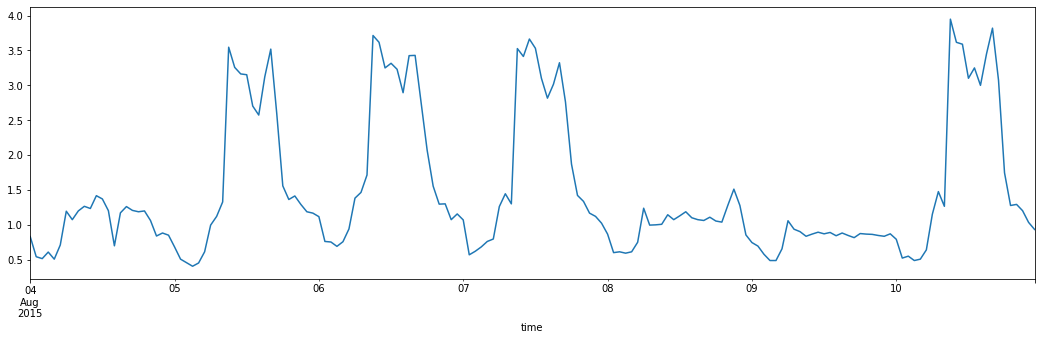

In [24]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [25]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [26]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [27]:
socket_pred2 = data_socket.loc[: "2015-08-10 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [28]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063357
0:	learn: 1.9149907	total: 55.9ms	remaining: 55.8s
1:	learn: 1.8253912	total: 57.9ms	remaining: 28.9s
2:	learn: 1.7437267	total: 60ms	remaining: 19.9s
3:	learn: 1.6675864	total: 62ms	remaining: 15.4s
4:	learn: 1.5970328	total: 64ms	remaining: 12.7s
5:	learn: 1.5322906	total: 66ms	remaining: 10.9s
6:	learn: 1.4725279	total: 68.1ms	remaining: 9.65s
7:	learn: 1.4175430	total: 70.1ms	remaining: 8.69s
8:	learn: 1.3677487	total: 72ms	remaining: 7.93s
9:	learn: 1.3214854	total: 74ms	remaining: 7.33s
10:	learn: 1.2797198	total: 76ms	remaining: 6.83s
11:	learn: 1.2416612	total: 78.3ms	remaining: 6.45s
12:	learn: 1.2066908	total: 80.3ms	remaining: 6.1s
13:	learn: 1.1751173	total: 82.4ms	remaining: 5.8s
14:	learn: 1.1459798	total: 84.5ms	remaining: 5.55s
15:	learn: 1.1186943	total: 86.5ms	remaining: 5.32s
16:	learn: 1.0940975	total: 88.7ms	remaining: 5.13s
17:	learn: 1.0722933	total: 90.7ms	remaining: 4.95s
18:	learn: 1.0524600	total: 92.8ms	remaining: 4.79s
19:	lear

252:	learn: 0.5763818	total: 546ms	remaining: 1.61s
253:	learn: 0.5760060	total: 548ms	remaining: 1.61s
254:	learn: 0.5756586	total: 550ms	remaining: 1.61s
255:	learn: 0.5751364	total: 552ms	remaining: 1.6s
256:	learn: 0.5746607	total: 554ms	remaining: 1.6s
257:	learn: 0.5742465	total: 556ms	remaining: 1.6s
258:	learn: 0.5734346	total: 558ms	remaining: 1.59s
259:	learn: 0.5729467	total: 560ms	remaining: 1.59s
260:	learn: 0.5727901	total: 561ms	remaining: 1.59s
261:	learn: 0.5722615	total: 563ms	remaining: 1.59s
262:	learn: 0.5714698	total: 565ms	remaining: 1.58s
263:	learn: 0.5711664	total: 567ms	remaining: 1.58s
264:	learn: 0.5709635	total: 569ms	remaining: 1.58s
265:	learn: 0.5705035	total: 571ms	remaining: 1.57s
266:	learn: 0.5700382	total: 573ms	remaining: 1.57s
267:	learn: 0.5696602	total: 575ms	remaining: 1.57s
268:	learn: 0.5691438	total: 577ms	remaining: 1.57s
269:	learn: 0.5682525	total: 579ms	remaining: 1.56s
270:	learn: 0.5677174	total: 581ms	remaining: 1.56s
271:	learn: 0.5

444:	learn: 0.5094619	total: 909ms	remaining: 1.13s
445:	learn: 0.5091994	total: 911ms	remaining: 1.13s
446:	learn: 0.5087601	total: 913ms	remaining: 1.13s
447:	learn: 0.5085339	total: 915ms	remaining: 1.13s
448:	learn: 0.5083766	total: 917ms	remaining: 1.13s
449:	learn: 0.5081248	total: 919ms	remaining: 1.12s
450:	learn: 0.5079103	total: 921ms	remaining: 1.12s
451:	learn: 0.5076666	total: 923ms	remaining: 1.12s
452:	learn: 0.5074804	total: 925ms	remaining: 1.12s
453:	learn: 0.5070601	total: 926ms	remaining: 1.11s
454:	learn: 0.5066088	total: 928ms	remaining: 1.11s
455:	learn: 0.5064789	total: 930ms	remaining: 1.11s
456:	learn: 0.5063439	total: 932ms	remaining: 1.11s
457:	learn: 0.5060989	total: 934ms	remaining: 1.1s
458:	learn: 0.5059495	total: 936ms	remaining: 1.1s
459:	learn: 0.5057301	total: 938ms	remaining: 1.1s
460:	learn: 0.5054073	total: 940ms	remaining: 1.1s
461:	learn: 0.5050711	total: 942ms	remaining: 1.1s
462:	learn: 0.5047636	total: 943ms	remaining: 1.09s
463:	learn: 0.504

635:	learn: 0.4707223	total: 1.27s	remaining: 727ms
636:	learn: 0.4703181	total: 1.27s	remaining: 725ms
637:	learn: 0.4701524	total: 1.27s	remaining: 723ms
638:	learn: 0.4699475	total: 1.28s	remaining: 721ms
639:	learn: 0.4698446	total: 1.28s	remaining: 719ms
640:	learn: 0.4695892	total: 1.28s	remaining: 717ms
641:	learn: 0.4694668	total: 1.28s	remaining: 715ms
642:	learn: 0.4691589	total: 1.28s	remaining: 713ms
643:	learn: 0.4689536	total: 1.28s	remaining: 711ms
644:	learn: 0.4687622	total: 1.29s	remaining: 709ms
645:	learn: 0.4686554	total: 1.29s	remaining: 707ms
646:	learn: 0.4684782	total: 1.29s	remaining: 705ms
647:	learn: 0.4683397	total: 1.29s	remaining: 703ms
648:	learn: 0.4682442	total: 1.29s	remaining: 700ms
649:	learn: 0.4679462	total: 1.3s	remaining: 698ms
650:	learn: 0.4676383	total: 1.3s	remaining: 696ms
651:	learn: 0.4675179	total: 1.3s	remaining: 694ms
652:	learn: 0.4673684	total: 1.3s	remaining: 692ms
653:	learn: 0.4673057	total: 1.3s	remaining: 690ms
654:	learn: 0.467

822:	learn: 0.4415641	total: 1.63s	remaining: 350ms
823:	learn: 0.4414068	total: 1.63s	remaining: 348ms
824:	learn: 0.4412911	total: 1.63s	remaining: 346ms
825:	learn: 0.4411636	total: 1.63s	remaining: 344ms
826:	learn: 0.4409876	total: 1.64s	remaining: 342ms
827:	learn: 0.4408048	total: 1.64s	remaining: 340ms
828:	learn: 0.4407116	total: 1.64s	remaining: 338ms
829:	learn: 0.4405157	total: 1.64s	remaining: 336ms
830:	learn: 0.4404428	total: 1.64s	remaining: 334ms
831:	learn: 0.4403269	total: 1.65s	remaining: 332ms
832:	learn: 0.4402445	total: 1.65s	remaining: 330ms
833:	learn: 0.4401002	total: 1.65s	remaining: 328ms
834:	learn: 0.4400017	total: 1.65s	remaining: 326ms
835:	learn: 0.4399253	total: 1.65s	remaining: 324ms
836:	learn: 0.4398104	total: 1.65s	remaining: 322ms
837:	learn: 0.4397216	total: 1.66s	remaining: 320ms
838:	learn: 0.4395983	total: 1.66s	remaining: 318ms
839:	learn: 0.4394056	total: 1.66s	remaining: 316ms
840:	learn: 0.4392949	total: 1.66s	remaining: 314ms
841:	learn: 

<h5>构建xgboost</h5>

In [29]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [30]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [31]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-18 10:49:30,282 [INFO] loading LSTM model from ../models/LSTM_socket.h5


In [32]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

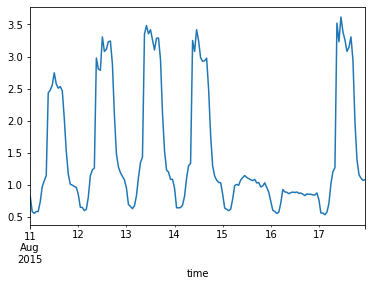

In [33]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4 + socket_pred5) / 5
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

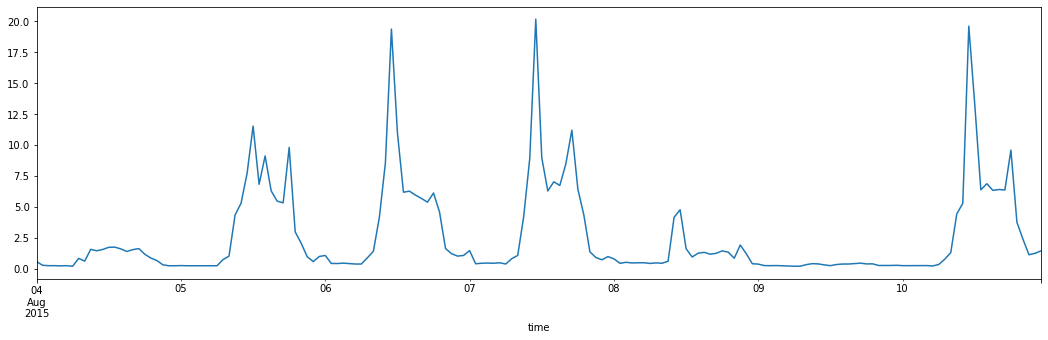

In [34]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [35]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [36]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [37]:
light_pred2 = data_light.loc[: "2015-08-10 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [38]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063357
0:	learn: 3.5451917	total: 2.16ms	remaining: 2.16s
1:	learn: 3.3801371	total: 4.21ms	remaining: 2.1s
2:	learn: 3.2283088	total: 6.17ms	remaining: 2.05s
3:	learn: 3.0888932	total: 8.22ms	remaining: 2.05s
4:	learn: 2.9611128	total: 10.4ms	remaining: 2.07s
5:	learn: 2.8443397	total: 12.4ms	remaining: 2.05s
6:	learn: 2.7349265	total: 14.3ms	remaining: 2.03s
7:	learn: 2.6375220	total: 16.3ms	remaining: 2.02s
8:	learn: 2.5464359	total: 18.2ms	remaining: 2.01s
9:	learn: 2.4623687	total: 20.1ms	remaining: 1.99s
10:	learn: 2.3860334	total: 22.1ms	remaining: 1.99s
11:	learn: 2.3181796	total: 24.1ms	remaining: 1.99s
12:	learn: 2.2546163	total: 26.1ms	remaining: 1.98s
13:	learn: 2.1930518	total: 28ms	remaining: 1.97s
14:	learn: 2.1361466	total: 33.2ms	remaining: 2.18s
15:	learn: 2.0911800	total: 35.1ms	remaining: 2.16s
16:	learn: 2.0421376	total: 37.1ms	remaining: 2.14s
17:	learn: 2.0003294	total: 39ms	remaining: 2.13s
18:	learn: 1.9622773	total: 41ms	remaining: 2.12s

192:	learn: 1.3198101	total: 350ms	remaining: 1.46s
193:	learn: 1.3184006	total: 351ms	remaining: 1.46s
194:	learn: 1.3177774	total: 353ms	remaining: 1.46s
195:	learn: 1.3168819	total: 355ms	remaining: 1.46s
196:	learn: 1.3157796	total: 357ms	remaining: 1.45s
197:	learn: 1.3144779	total: 358ms	remaining: 1.45s
198:	learn: 1.3132562	total: 360ms	remaining: 1.45s
199:	learn: 1.3123695	total: 362ms	remaining: 1.45s
200:	learn: 1.3116978	total: 364ms	remaining: 1.45s
201:	learn: 1.3106028	total: 365ms	remaining: 1.44s
202:	learn: 1.3098855	total: 367ms	remaining: 1.44s
203:	learn: 1.3091921	total: 369ms	remaining: 1.44s
204:	learn: 1.3087135	total: 371ms	remaining: 1.44s
205:	learn: 1.3083558	total: 373ms	remaining: 1.44s
206:	learn: 1.3077383	total: 374ms	remaining: 1.43s
207:	learn: 1.3064299	total: 376ms	remaining: 1.43s
208:	learn: 1.3052573	total: 378ms	remaining: 1.43s
209:	learn: 1.3047633	total: 380ms	remaining: 1.43s
210:	learn: 1.3041645	total: 382ms	remaining: 1.43s
211:	learn: 

407:	learn: 1.1815991	total: 721ms	remaining: 1.05s
408:	learn: 1.1810050	total: 723ms	remaining: 1.04s
409:	learn: 1.1803151	total: 725ms	remaining: 1.04s
410:	learn: 1.1799525	total: 727ms	remaining: 1.04s
411:	learn: 1.1793491	total: 728ms	remaining: 1.04s
412:	learn: 1.1786221	total: 730ms	remaining: 1.04s
413:	learn: 1.1780331	total: 732ms	remaining: 1.04s
414:	learn: 1.1776016	total: 734ms	remaining: 1.03s
415:	learn: 1.1768731	total: 736ms	remaining: 1.03s
416:	learn: 1.1765481	total: 737ms	remaining: 1.03s
417:	learn: 1.1762668	total: 739ms	remaining: 1.03s
418:	learn: 1.1759005	total: 741ms	remaining: 1.03s
419:	learn: 1.1755446	total: 743ms	remaining: 1.02s
420:	learn: 1.1751714	total: 745ms	remaining: 1.02s
421:	learn: 1.1749348	total: 746ms	remaining: 1.02s
422:	learn: 1.1742256	total: 748ms	remaining: 1.02s
423:	learn: 1.1739057	total: 750ms	remaining: 1.02s
424:	learn: 1.1732656	total: 752ms	remaining: 1.02s
425:	learn: 1.1729251	total: 753ms	remaining: 1.01s
426:	learn: 

613:	learn: 1.0993493	total: 1.08s	remaining: 681ms
614:	learn: 1.0991159	total: 1.08s	remaining: 680ms
615:	learn: 1.0987159	total: 1.09s	remaining: 678ms
616:	learn: 1.0984938	total: 1.09s	remaining: 676ms
617:	learn: 1.0981895	total: 1.09s	remaining: 674ms
618:	learn: 1.0975269	total: 1.09s	remaining: 673ms
619:	learn: 1.0969079	total: 1.09s	remaining: 671ms
620:	learn: 1.0965852	total: 1.1s	remaining: 669ms
621:	learn: 1.0964429	total: 1.1s	remaining: 667ms
622:	learn: 1.0961805	total: 1.1s	remaining: 665ms
623:	learn: 1.0957189	total: 1.1s	remaining: 664ms
624:	learn: 1.0954109	total: 1.1s	remaining: 662ms
625:	learn: 1.0952066	total: 1.1s	remaining: 660ms
626:	learn: 1.0950213	total: 1.11s	remaining: 658ms
627:	learn: 1.0948201	total: 1.11s	remaining: 657ms
628:	learn: 1.0946520	total: 1.11s	remaining: 655ms
629:	learn: 1.0945082	total: 1.11s	remaining: 653ms
630:	learn: 1.0940876	total: 1.11s	remaining: 651ms
631:	learn: 1.0938907	total: 1.11s	remaining: 649ms
632:	learn: 1.0937

831:	learn: 1.0329391	total: 1.47s	remaining: 296ms
832:	learn: 1.0326593	total: 1.47s	remaining: 294ms
833:	learn: 1.0323395	total: 1.47s	remaining: 293ms
834:	learn: 1.0318416	total: 1.47s	remaining: 291ms
835:	learn: 1.0315665	total: 1.47s	remaining: 289ms
836:	learn: 1.0309870	total: 1.48s	remaining: 287ms
837:	learn: 1.0308100	total: 1.48s	remaining: 286ms
838:	learn: 1.0305699	total: 1.48s	remaining: 284ms
839:	learn: 1.0304850	total: 1.48s	remaining: 282ms
840:	learn: 1.0302257	total: 1.48s	remaining: 280ms
841:	learn: 1.0300808	total: 1.49s	remaining: 279ms
842:	learn: 1.0298789	total: 1.49s	remaining: 277ms
843:	learn: 1.0295676	total: 1.49s	remaining: 275ms
844:	learn: 1.0294057	total: 1.49s	remaining: 273ms
845:	learn: 1.0289296	total: 1.49s	remaining: 272ms
846:	learn: 1.0287479	total: 1.49s	remaining: 270ms
847:	learn: 1.0285950	total: 1.5s	remaining: 268ms
848:	learn: 1.0284305	total: 1.5s	remaining: 266ms
849:	learn: 1.0282097	total: 1.5s	remaining: 265ms
850:	learn: 1.0

<h5>构建xgboost</h5>

In [39]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [40]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

In [41]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light.h5")
    logging.info("loading LSTM model from ../models/LSTM_light.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light.h5")
    logging.info("saving LSTM model to ../models/LSTM_light.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-18 10:49:38,230 [INFO] loading LSTM model from ../models/LSTM_light.h5


In [42]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

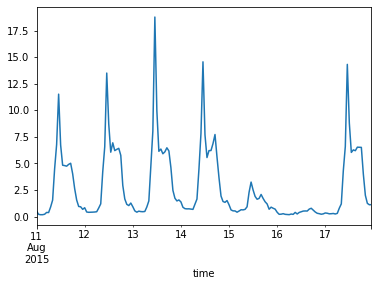

In [43]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4 + light_pred5) / 5
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

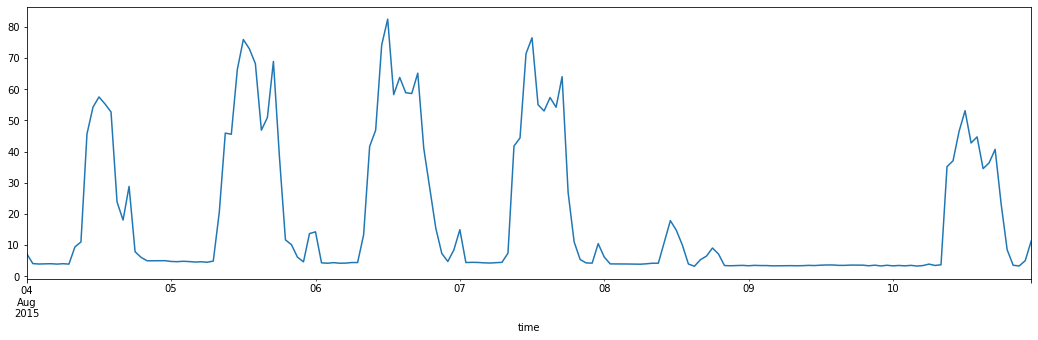

In [44]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [45]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [46]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [47]:
air_pred2 = data_air.loc[: "2015-08-10 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [48]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063357
0:	learn: 14.1010648	total: 2.77ms	remaining: 2.76s
1:	learn: 13.5535529	total: 5.44ms	remaining: 2.71s
2:	learn: 13.0645450	total: 7.86ms	remaining: 2.61s
3:	learn: 12.6199125	total: 10.4ms	remaining: 2.59s
4:	learn: 12.2041335	total: 12.8ms	remaining: 2.55s
5:	learn: 11.8093025	total: 15.2ms	remaining: 2.52s
6:	learn: 11.4531427	total: 17.6ms	remaining: 2.5s
7:	learn: 11.1296388	total: 20.1ms	remaining: 2.5s
8:	learn: 10.8390440	total: 22.7ms	remaining: 2.5s
9:	learn: 10.5690688	total: 25ms	remaining: 2.47s
10:	learn: 10.3217384	total: 27.5ms	remaining: 2.47s
11:	learn: 10.0827034	total: 29.9ms	remaining: 2.46s
12:	learn: 9.8755197	total: 32.2ms	remaining: 2.44s
13:	learn: 9.6743932	total: 34.5ms	remaining: 2.43s
14:	learn: 9.5037659	total: 36.9ms	remaining: 2.42s
15:	learn: 9.3488606	total: 39.1ms	remaining: 2.41s
16:	learn: 9.2005284	total: 41.6ms	remaining: 2.4s
17:	learn: 9.0570565	total: 44ms	remaining: 2.4s
18:	learn: 8.9303708	total: 46.4ms	remain

167:	learn: 5.5785643	total: 349ms	remaining: 1.73s
168:	learn: 5.5735409	total: 351ms	remaining: 1.73s
169:	learn: 5.5670487	total: 353ms	remaining: 1.72s
170:	learn: 5.5597791	total: 355ms	remaining: 1.72s
171:	learn: 5.5541357	total: 357ms	remaining: 1.72s
172:	learn: 5.5483181	total: 359ms	remaining: 1.72s
173:	learn: 5.5414777	total: 361ms	remaining: 1.72s
174:	learn: 5.5324570	total: 364ms	remaining: 1.71s
175:	learn: 5.5227723	total: 366ms	remaining: 1.71s
176:	learn: 5.5137833	total: 368ms	remaining: 1.71s
177:	learn: 5.5069337	total: 370ms	remaining: 1.71s
178:	learn: 5.5024675	total: 372ms	remaining: 1.71s
179:	learn: 5.4942811	total: 374ms	remaining: 1.7s
180:	learn: 5.4886142	total: 376ms	remaining: 1.7s
181:	learn: 5.4793594	total: 378ms	remaining: 1.7s
182:	learn: 5.4743156	total: 380ms	remaining: 1.7s
183:	learn: 5.4655449	total: 382ms	remaining: 1.7s
184:	learn: 5.4601775	total: 384ms	remaining: 1.69s
185:	learn: 5.4554009	total: 386ms	remaining: 1.69s
186:	learn: 5.446

351:	learn: 4.5495307	total: 715ms	remaining: 1.32s
352:	learn: 4.5460440	total: 717ms	remaining: 1.31s
353:	learn: 4.5417442	total: 719ms	remaining: 1.31s
354:	learn: 4.5398283	total: 721ms	remaining: 1.31s
355:	learn: 4.5351624	total: 724ms	remaining: 1.31s
356:	learn: 4.5313110	total: 726ms	remaining: 1.31s
357:	learn: 4.5277803	total: 728ms	remaining: 1.3s
358:	learn: 4.5242095	total: 729ms	remaining: 1.3s
359:	learn: 4.5223752	total: 731ms	remaining: 1.3s
360:	learn: 4.5187044	total: 734ms	remaining: 1.3s
361:	learn: 4.5149637	total: 736ms	remaining: 1.3s
362:	learn: 4.5125236	total: 738ms	remaining: 1.29s
363:	learn: 4.5105198	total: 740ms	remaining: 1.29s
364:	learn: 4.5079572	total: 742ms	remaining: 1.29s
365:	learn: 4.5028838	total: 744ms	remaining: 1.29s
366:	learn: 4.5003793	total: 746ms	remaining: 1.28s
367:	learn: 4.4971778	total: 747ms	remaining: 1.28s
368:	learn: 4.4950459	total: 749ms	remaining: 1.28s
369:	learn: 4.4930393	total: 751ms	remaining: 1.28s
370:	learn: 4.490

536:	learn: 4.0509262	total: 1.08s	remaining: 934ms
537:	learn: 4.0489931	total: 1.08s	remaining: 932ms
538:	learn: 4.0466851	total: 1.09s	remaining: 930ms
539:	learn: 4.0442083	total: 1.09s	remaining: 928ms
540:	learn: 4.0413187	total: 1.09s	remaining: 926ms
541:	learn: 4.0398421	total: 1.09s	remaining: 924ms
542:	learn: 4.0376804	total: 1.09s	remaining: 922ms
543:	learn: 4.0352386	total: 1.1s	remaining: 920ms
544:	learn: 4.0316404	total: 1.1s	remaining: 918ms
545:	learn: 4.0296272	total: 1.1s	remaining: 916ms
546:	learn: 4.0263098	total: 1.1s	remaining: 914ms
547:	learn: 4.0248053	total: 1.11s	remaining: 912ms
548:	learn: 4.0225661	total: 1.11s	remaining: 910ms
549:	learn: 4.0205679	total: 1.11s	remaining: 908ms
550:	learn: 4.0187807	total: 1.11s	remaining: 906ms
551:	learn: 4.0172288	total: 1.11s	remaining: 904ms
552:	learn: 4.0151880	total: 1.12s	remaining: 902ms
553:	learn: 4.0117469	total: 1.12s	remaining: 900ms
554:	learn: 4.0090263	total: 1.12s	remaining: 898ms
555:	learn: 4.00

783:	learn: 3.5874309	total: 1.63s	remaining: 449ms
784:	learn: 3.5867128	total: 1.63s	remaining: 447ms
785:	learn: 3.5847643	total: 1.63s	remaining: 445ms
786:	learn: 3.5837411	total: 1.63s	remaining: 442ms
787:	learn: 3.5829543	total: 1.64s	remaining: 440ms
788:	learn: 3.5825237	total: 1.64s	remaining: 438ms
789:	learn: 3.5815295	total: 1.64s	remaining: 436ms
790:	learn: 3.5808003	total: 1.64s	remaining: 434ms
791:	learn: 3.5791073	total: 1.65s	remaining: 432ms
792:	learn: 3.5782534	total: 1.65s	remaining: 430ms
793:	learn: 3.5769164	total: 1.65s	remaining: 428ms
794:	learn: 3.5757920	total: 1.65s	remaining: 426ms
795:	learn: 3.5743404	total: 1.65s	remaining: 424ms
796:	learn: 3.5738534	total: 1.66s	remaining: 422ms
797:	learn: 3.5714475	total: 1.66s	remaining: 420ms
798:	learn: 3.5682128	total: 1.66s	remaining: 417ms
799:	learn: 3.5665777	total: 1.66s	remaining: 415ms
800:	learn: 3.5653534	total: 1.66s	remaining: 413ms
801:	learn: 3.5644324	total: 1.67s	remaining: 411ms
802:	learn: 

964:	learn: 3.3430194	total: 1.99s	remaining: 72.2ms
965:	learn: 3.3419769	total: 1.99s	remaining: 70.1ms
966:	learn: 3.3409203	total: 1.99s	remaining: 68ms
967:	learn: 3.3393506	total: 2s	remaining: 66ms
968:	learn: 3.3388732	total: 2s	remaining: 63.9ms
969:	learn: 3.3382090	total: 2s	remaining: 61.9ms
970:	learn: 3.3370940	total: 2s	remaining: 59.8ms
971:	learn: 3.3359973	total: 2s	remaining: 57.7ms
972:	learn: 3.3352320	total: 2.01s	remaining: 55.7ms
973:	learn: 3.3344837	total: 2.01s	remaining: 53.6ms
974:	learn: 3.3337455	total: 2.01s	remaining: 51.5ms
975:	learn: 3.3325222	total: 2.01s	remaining: 49.5ms
976:	learn: 3.3310323	total: 2.01s	remaining: 47.4ms
977:	learn: 3.3307119	total: 2.02s	remaining: 45.4ms
978:	learn: 3.3299462	total: 2.02s	remaining: 43.3ms
979:	learn: 3.3293931	total: 2.02s	remaining: 41.2ms
980:	learn: 3.3278312	total: 2.02s	remaining: 39.2ms
981:	learn: 3.3268978	total: 2.02s	remaining: 37.1ms
982:	learn: 3.3255008	total: 2.03s	remaining: 35ms
983:	learn: 3.

<h5>构建xgboost</h5>

In [49]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [50]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 44ms/step - loss: 445.4151 - mae: 13.2782
Epoch 2/100
124/124 [==============================] - 5s 40ms/step - loss: 265.3732 - mae: 9.8461
Epoch 3/100
124/124 [==============================] - 5s 40ms/step - loss: 117.2503 - mae: 6.5871
Epoch 4/100
124/124 [==============================] - 5s 39ms/step - loss: 81.4541 - mae: 5.5863
Epoch 5/100
124/124 [==============================] - 5s 40ms/step - loss: 71.4899 - mae: 5.2771
Epoch 6/100
124/124 [==============================] - 5s 39ms/step - loss: 61.5461 - mae: 4.8650
Epoch 7/100
124/124 [==============================] - 5s 40ms/step - loss: 54.0763 - mae: 4.5931
Epoch 8/100
124/124 [==============================] - 5s 40ms/step - loss: 47.7861 - mae: 4.3114
Epoch 9/100
124/124 [==============================] - 5s 40ms/step - loss: 41.7255 - mae: 4.0393
Epoch 10/100
124/124 [==============================] - 5s 40ms/step - loss: 40.3016 - mae: 3.9709
Epoch 11/100
12

124/124 [==============================] - 5s 41ms/step - loss: 3.3363 - mae: 1.0432
Epoch 85/100
124/124 [==============================] - 5s 41ms/step - loss: 2.8709 - mae: 0.9673
Epoch 86/100
124/124 [==============================] - 5s 41ms/step - loss: 2.8017 - mae: 0.9577
Epoch 87/100
124/124 [==============================] - 5s 42ms/step - loss: 2.8660 - mae: 0.9703
Epoch 88/100
124/124 [==============================] - 5s 41ms/step - loss: 2.7358 - mae: 0.9441
Epoch 89/100
124/124 [==============================] - 5s 41ms/step - loss: 2.6498 - mae: 0.9218
Epoch 90/100
124/124 [==============================] - 5s 41ms/step - loss: 3.0857 - mae: 1.0163
Epoch 91/100
124/124 [==============================] - 5s 42ms/step - loss: 2.8725 - mae: 0.9676
Epoch 92/100
124/124 [==============================] - 5s 42ms/step - loss: 2.5686 - mae: 0.9068
Epoch 93/100
124/124 [==============================] - 5s 42ms/step - loss: 2.6774 - mae: 0.9245
Epoch 94/100
124/124 [===========

2023-04-18 10:58:18,566 [INFO] saving LSTM model to ../models/LSTM_air.h5


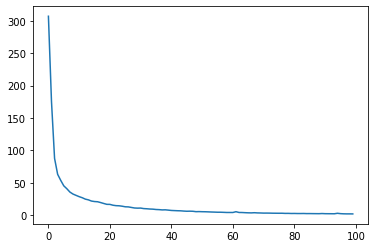

In [51]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air.h5")
    logging.info("loading LSTM model from ../models/LSTM_air.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_air.h5")
    logging.info("saving LSTM model to ../models/LSTM_air.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [52]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

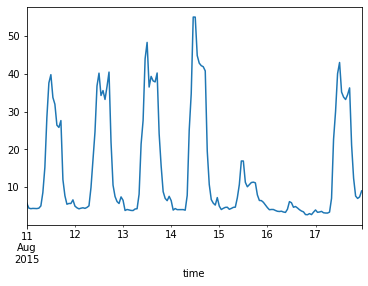

In [53]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4 + air_pred5) / 5
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

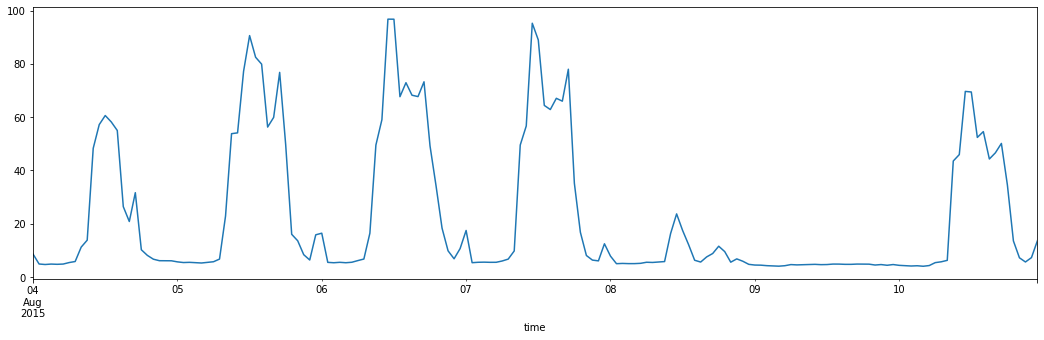

In [54]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [55]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [56]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [57]:
total_pred2 = data_total.loc[: "2015-08-10 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [58]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063357
0:	learn: 17.9276375	total: 3.46ms	remaining: 3.46s
1:	learn: 17.1601980	total: 6.48ms	remaining: 3.23s
2:	learn: 16.4567232	total: 9.61ms	remaining: 3.19s
3:	learn: 15.8084956	total: 12.6ms	remaining: 3.13s
4:	learn: 15.2151291	total: 15.8ms	remaining: 3.13s
5:	learn: 14.6656380	total: 18.7ms	remaining: 3.1s
6:	learn: 14.1577508	total: 21.7ms	remaining: 3.08s
7:	learn: 13.6980842	total: 24.7ms	remaining: 3.06s
8:	learn: 13.2673776	total: 27.8ms	remaining: 3.06s
9:	learn: 12.8845800	total: 30.7ms	remaining: 3.04s
10:	learn: 12.5227027	total: 33.7ms	remaining: 3.02s
11:	learn: 12.2018150	total: 36.7ms	remaining: 3.02s
12:	learn: 11.8992926	total: 39.7ms	remaining: 3.02s
13:	learn: 11.6292223	total: 42.8ms	remaining: 3.01s
14:	learn: 11.3720728	total: 45.4ms	remaining: 2.98s
15:	learn: 11.1417363	total: 47.9ms	remaining: 2.95s
16:	learn: 10.9274489	total: 50.5ms	remaining: 2.92s
17:	learn: 10.7265798	total: 53ms	remaining: 2.89s
18:	learn: 10.5606852	total: 

211:	learn: 5.9468725	total: 527ms	remaining: 1.96s
212:	learn: 5.9434638	total: 530ms	remaining: 1.96s
213:	learn: 5.9382315	total: 532ms	remaining: 1.96s
214:	learn: 5.9310343	total: 535ms	remaining: 1.95s
215:	learn: 5.9270677	total: 537ms	remaining: 1.95s
216:	learn: 5.9220757	total: 540ms	remaining: 1.95s
217:	learn: 5.9139432	total: 542ms	remaining: 1.95s
218:	learn: 5.9091452	total: 545ms	remaining: 1.94s
219:	learn: 5.9041645	total: 547ms	remaining: 1.94s
220:	learn: 5.8988425	total: 550ms	remaining: 1.94s
221:	learn: 5.8925553	total: 552ms	remaining: 1.94s
222:	learn: 5.8877148	total: 555ms	remaining: 1.93s
223:	learn: 5.8745521	total: 557ms	remaining: 1.93s
224:	learn: 5.8618515	total: 560ms	remaining: 1.93s
225:	learn: 5.8567669	total: 562ms	remaining: 1.93s
226:	learn: 5.8453912	total: 565ms	remaining: 1.92s
227:	learn: 5.8407270	total: 567ms	remaining: 1.92s
228:	learn: 5.8310206	total: 570ms	remaining: 1.92s
229:	learn: 5.8264362	total: 572ms	remaining: 1.91s
230:	learn: 

438:	learn: 4.8723624	total: 1.08s	remaining: 1.38s
439:	learn: 4.8690539	total: 1.08s	remaining: 1.38s
440:	learn: 4.8669289	total: 1.08s	remaining: 1.37s
441:	learn: 4.8638455	total: 1.09s	remaining: 1.37s
442:	learn: 4.8604789	total: 1.09s	remaining: 1.37s
443:	learn: 4.8573294	total: 1.09s	remaining: 1.37s
444:	learn: 4.8529906	total: 1.09s	remaining: 1.36s
445:	learn: 4.8498346	total: 1.1s	remaining: 1.36s
446:	learn: 4.8472907	total: 1.1s	remaining: 1.36s
447:	learn: 4.8440060	total: 1.1s	remaining: 1.36s
448:	learn: 4.8413878	total: 1.1s	remaining: 1.35s
449:	learn: 4.8381418	total: 1.1s	remaining: 1.35s
450:	learn: 4.8348511	total: 1.11s	remaining: 1.35s
451:	learn: 4.8325171	total: 1.11s	remaining: 1.35s
452:	learn: 4.8295447	total: 1.11s	remaining: 1.34s
453:	learn: 4.8261480	total: 1.11s	remaining: 1.34s
454:	learn: 4.8235675	total: 1.12s	remaining: 1.34s
455:	learn: 4.8213854	total: 1.12s	remaining: 1.34s
456:	learn: 4.8184808	total: 1.12s	remaining: 1.33s
457:	learn: 4.816

663:	learn: 4.3017324	total: 1.62s	remaining: 820ms
664:	learn: 4.2988294	total: 1.62s	remaining: 818ms
665:	learn: 4.2972456	total: 1.63s	remaining: 815ms
666:	learn: 4.2962600	total: 1.63s	remaining: 813ms
667:	learn: 4.2930523	total: 1.63s	remaining: 810ms
668:	learn: 4.2920506	total: 1.63s	remaining: 808ms
669:	learn: 4.2882218	total: 1.64s	remaining: 806ms
670:	learn: 4.2874674	total: 1.64s	remaining: 803ms
671:	learn: 4.2856571	total: 1.64s	remaining: 801ms
672:	learn: 4.2820899	total: 1.64s	remaining: 798ms
673:	learn: 4.2805143	total: 1.65s	remaining: 796ms
674:	learn: 4.2787559	total: 1.65s	remaining: 793ms
675:	learn: 4.2765384	total: 1.65s	remaining: 791ms
676:	learn: 4.2742109	total: 1.65s	remaining: 788ms
677:	learn: 4.2710370	total: 1.65s	remaining: 786ms
678:	learn: 4.2700483	total: 1.66s	remaining: 783ms
679:	learn: 4.2690811	total: 1.66s	remaining: 781ms
680:	learn: 4.2663217	total: 1.66s	remaining: 778ms
681:	learn: 4.2632282	total: 1.66s	remaining: 776ms
682:	learn: 

891:	learn: 3.9149873	total: 2.17s	remaining: 263ms
892:	learn: 3.9137269	total: 2.17s	remaining: 261ms
893:	learn: 3.9127564	total: 2.18s	remaining: 258ms
894:	learn: 3.9116087	total: 2.19s	remaining: 257ms
895:	learn: 3.9103991	total: 2.19s	remaining: 254ms
896:	learn: 3.9080193	total: 2.19s	remaining: 252ms
897:	learn: 3.9065723	total: 2.2s	remaining: 249ms
898:	learn: 3.9052048	total: 2.2s	remaining: 247ms
899:	learn: 3.9012719	total: 2.2s	remaining: 245ms
900:	learn: 3.8998840	total: 2.2s	remaining: 242ms
901:	learn: 3.8990644	total: 2.21s	remaining: 240ms
902:	learn: 3.8970292	total: 2.21s	remaining: 237ms
903:	learn: 3.8963486	total: 2.21s	remaining: 235ms
904:	learn: 3.8948003	total: 2.21s	remaining: 232ms
905:	learn: 3.8937251	total: 2.21s	remaining: 230ms
906:	learn: 3.8929731	total: 2.22s	remaining: 227ms
907:	learn: 3.8910280	total: 2.22s	remaining: 225ms
908:	learn: 3.8901970	total: 2.22s	remaining: 223ms
909:	learn: 3.8886584	total: 2.23s	remaining: 220ms
910:	learn: 3.88

<h5>构建xgboost</h5>

In [59]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:linear', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

[10:58:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<h5>构建深度模型</h5>

In [60]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [61]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total.h5")
    logging.info("loading LSTM model from ../models/LSTM_total.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total.h5")
    logging.info("saving LSTM model to ../models/LSTM_total.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-18 10:58:26,743 [INFO] loading LSTM model from ../models/LSTM_total.h5


In [62]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

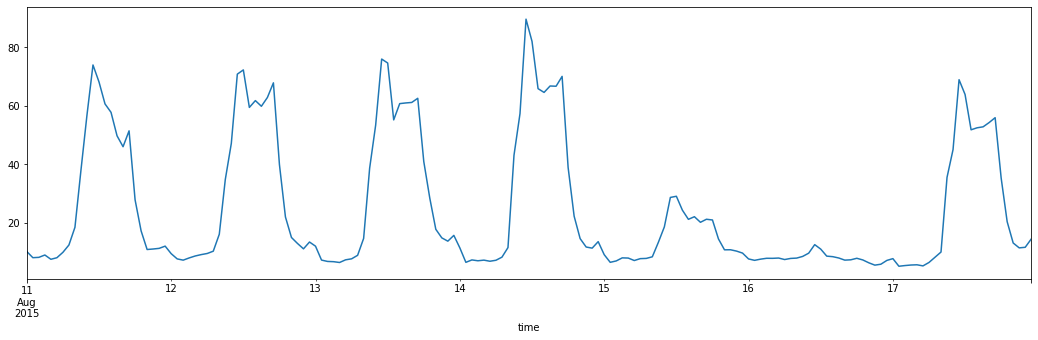

In [63]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4 + total_pred5) / 5
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred * 1.314
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [64]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,7.772585,0.825440,0.518041,5.792612
2015-08-11 01:00:00,6.172903,0.585055,0.208151,4.515539
2015-08-11 02:00:00,6.257573,0.556784,0.174232,4.369225
2015-08-11 03:00:00,6.867448,0.584745,0.176506,4.436222
2015-08-11 04:00:00,5.755523,0.586104,0.216413,4.408312
...,...,...,...,...
2015-08-17 19:00:00,15.525287,1.393869,3.984230,12.401457
2015-08-17 20:00:00,9.991894,1.160002,1.999930,7.699543
2015-08-17 21:00:00,8.724197,1.104813,1.244317,7.068365
2015-08-17 22:00:00,8.871725,1.070922,1.111709,7.475376


In [65]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)